<a href="https://colab.research.google.com/github/Bhanukoya/Time-Series-Prediction/blob/master/Time_series_pros_using_RNNs_%26_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [124]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20 # taking 20 time steps as input
window = window_size + 1

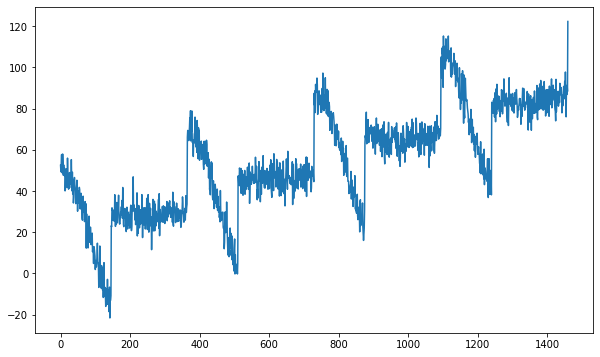

In [125]:
plt.figure(figsize=(10,6))
plt.plot(time, series)

In [126]:
len(series)

1461

In [127]:
len(x_train)

1000

In [128]:
len(x_valid)

461

In [129]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.window(window, shift=1, drop_remainder=True)

In [130]:
li = []
for i in dataset: 
  s_li = []
  for j in i:
    s_li.append(j.numpy())
  li.append(s_li)


In [131]:
len(li)

980

In [132]:
import random
random.seed(3)

In [133]:
random.shuffle(li)

In [134]:
x = []
y = []

for i in li:
  x.append(i[0:-1])
  y.append(i[-1])

In [135]:
x = np.array(x)
y = np.array(y)

In [136]:
x.shape

(980, 20)

In [137]:
x = x.reshape(980, 20, 1)
x.shape

(980, 20, 1)

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, Lambda

In [139]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr = LearningRateScheduler( lambda epoch :  1e-8 *(10**(epoch/20)))

## Using RNNS

In [140]:
model  = Sequential()
model.add(SimpleRNN(units=40 , input_shape = [None, 1], return_sequences=True))
model.add(SimpleRNN(40))
model.add(Dense(1))
model.add(Lambda( lambda x: x*100))  # scaling the output

In [141]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model.compile(optimizer=SGD(lr = 1e-8, momentum=0.9), loss = Huber(), metrics=['mae'])
history = model.fit(x, y , verbose=1, epochs=100, batch_size=32, callbacks=[lr])

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 125.8972 - mae: 126.3972 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 122.5607 - mae: 123.0607 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 118.6238 - mae: 119.1238 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 114.2974 - mae: 114.7974 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 109.5778 - mae: 110.0773 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 104.4191 - mae: 104.9190 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 98.7657 - mae: 99.2657 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 92.5878 - mae: 93.0878 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 85.8235 - m

(1e-08, 0.0001, 0.0, 30.0)

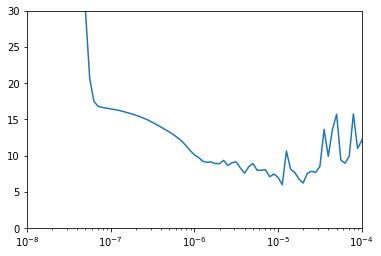

In [142]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### Rerun by taking the lr at minimum and stable loss

In [143]:
model  = Sequential()
model.add(SimpleRNN(units=40 , input_shape = [None, 1], return_sequences=True))
model.add(SimpleRNN(40))
model.add(Dense(1))
model.add(Lambda( lambda x: x*100))  # scaling the output

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model.compile(optimizer=SGD(lr = 5e-6, momentum=0.9), loss = Huber(), metrics=['mae'])  # Huber loss is less sensitive to outliers
history = model.fit(x, y , verbose=1, epochs=500, batch_size=32)

Epoch 1/500
31/31 [==============================] - 0s 7ms/step - loss: 38.9955 - mae: 39.4920
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 10.3172 - mae: 10.8042
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 8.8092 - mae: 9.2962
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.5926 - mae: 8.0778
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 7.1065 - mae: 7.5905
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 6.8009 - mae: 7.2844
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 6.4916 - mae: 6.9767
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 6.4380 - mae: 6.9210
Epoch 9/500
31/31 [==============================] - 0s 8ms/step - loss: 7.0569 - mae: 7.5421
Epoch 10/500
31/31 [==============================] - 0s 8ms/step - loss: 5.8087 - mae: 6.2891
Epoch 11/500
31/31 [==============================] - 0

In [144]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [145]:
prediction = []
for i in range(len(series) - window_size):
  example = series[i: i+ window_size]
  example = example.reshape(1,window_size,1)
  prediction.append(model.predict(example).reshape(1,))

In [146]:
len(prediction)

1441

In [147]:
print(prediction)

[array([42.519836], dtype=float32), array([44.996433], dtype=float32), array([44.35796], dtype=float32), array([45.931656], dtype=float32), array([43.994884], dtype=float32), array([42.928802], dtype=float32), array([42.8941], dtype=float32), array([42.32395], dtype=float32), array([43.29012], dtype=float32), array([42.05905], dtype=float32), array([42.873085], dtype=float32), array([41.85611], dtype=float32), array([44.568718], dtype=float32), array([44.059467], dtype=float32), array([43.34324], dtype=float32), array([43.66809], dtype=float32), array([40.629642], dtype=float32), array([42.075684], dtype=float32), array([38.391148], dtype=float32), array([37.735794], dtype=float32), array([37.181957], dtype=float32), array([39.35439], dtype=float32), array([40.287674], dtype=float32), array([40.098785], dtype=float32), array([39.304317], dtype=float32), array([37.372868], dtype=float32), array([36.249344], dtype=float32), array([35.162987], dtype=float32), array([37.51489], dtype=float

In [148]:
forecast = prediction[split_time - window_size:]

In [149]:
len(forecast)

461

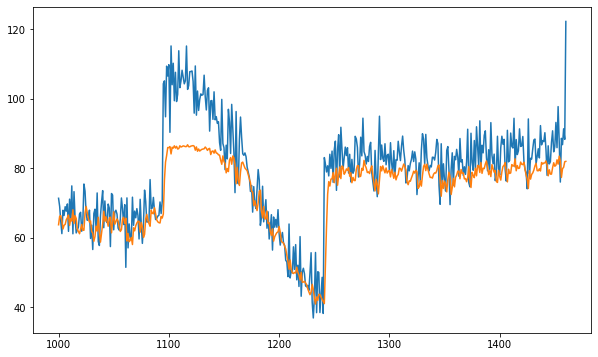

In [150]:
plt.figure(figsize=(10,6))
plt.plot( time_valid,  x_valid)
plt.plot(time_valid, forecast)


In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(mean_absolute_error(x_valid, forecast))

6.896897


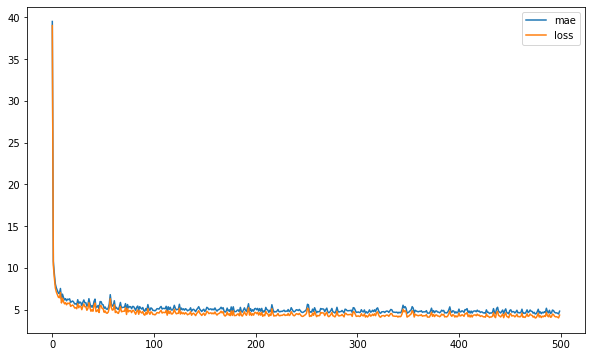

In [152]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(500), history.history['mae'], label = 'mae' )
plt.plot(np.arange(500), history.history['loss'], label = 'loss')
plt.legend()

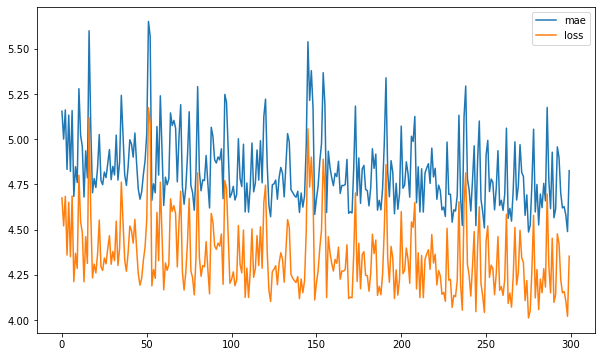

In [153]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(300), history.history['mae'][200:] , label = 'mae')
plt.plot(np.arange(300), history.history['loss'][200:] , label = 'loss')
plt.legend()

## Using lambda layer as first layer (for reference)

---



In [154]:
mode  = Sequential()
mode.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]))
mode.add(SimpleRNN(units=40 , return_sequences=True))
mode.add(SimpleRNN(40))
mode.add(Dense(1))
mode.add(Lambda(lambda x: x*100))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

mode.compile(optimizer=SGD(lr = 1e-8, momentum=0.9), loss = Huber(), metrics=['mae'])
mode.fit(x, y , verbose=1, epochs=100, batch_size=32, callbacks=[lr])

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 49.0894 - mae: 49.5891 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 46.8500 - mae: 47.3498 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 44.1294 - mae: 44.6292 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 41.0609 - mae: 41.5606 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 37.6285 - mae: 38.1267 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 33.8494 - mae: 34.3477 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 29.7254 - mae: 30.2241 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 25.3330 - mae: 25.8303 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 20.8636 - mae: 21.3608 

## Using LSTMs

In [155]:
from tensorflow.keras.layers import Bidirectional, LSTM
tf.keras.backend.clear_session()

mode  = Sequential()
mode.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=[None, 1])))
mode.add(Bidirectional(LSTM(32)))
mode.add(Dense(1))
mode.add(Lambda(lambda x: x*100))

from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.losses import Huber

mode.compile(optimizer=SGD(lr = 1e-8, momentum=0.9), loss = Huber(), metrics=['mae'])
history = mode.fit(x, y , verbose=1, epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 1s 26ms/step - loss: 49.3642 - mae: 49.8636
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 48.7548 - mae: 49.2544
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 48.0876 - mae: 48.5874
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 47.4133 - mae: 47.9132
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 46.7336 - mae: 47.2330
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 46.0515 - mae: 46.5500
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 45.3602 - mae: 45.8589
Epoch 8/100
31/31 [==============================] - 1s 26ms/step - loss: 44.6637 - mae: 45.1623
Epoch 9/100
31/31 [==============================] - 1s 28ms/step - loss: 43.9607 - mae: 44.4584
Epoch 10/100
31/31 [==============================] - 1s 26ms/step - loss: 43.2534 - mae: 43.7513
Epoch 11/100
31/31 [=========

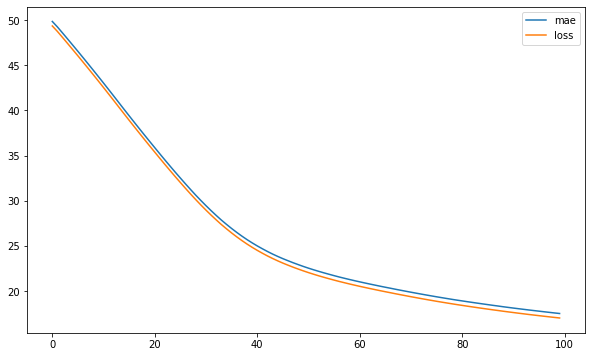

In [156]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(100), history.history['mae'], label = 'mae' )
plt.plot(np.arange(100), history.history['loss'], label = 'loss')
plt.legend()

## Using Lambda layers and LSTMs


In [157]:
tf.keras.backend.clear_session()

mode  = Sequential()
mode.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]))
mode.add(Bidirectional(LSTM(32, return_sequences=True)))
mode.add(Bidirectional(LSTM(32)))
mode.add(Dense(1))
mode.add(Lambda(lambda x: x*100))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

mode.compile(optimizer=SGD(lr = 1e-8, momentum=0.9), loss = Huber(), metrics=['mae'])
history = mode.fit(x, y , verbose=1, epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 1s 26ms/step - loss: 17.5367 - mae: 18.0266
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 16.8918 - mae: 17.3824
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 16.4259 - mae: 16.9166
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 16.1563 - mae: 16.6473
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 15.9147 - mae: 16.4059
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 15.6929 - mae: 16.1832
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 15.4858 - mae: 15.9767
Epoch 8/100
31/31 [==============================] - 1s 27ms/step - loss: 15.2953 - mae: 15.7874
Epoch 9/100
31/31 [==============================] - 1s 25ms/step - loss: 15.1122 - mae: 15.6044
Epoch 10/100
31/31 [==============================] - 1s 28ms/step - loss: 14.9435 - mae: 15.4351
Epoch 11/100
31/31 [=========

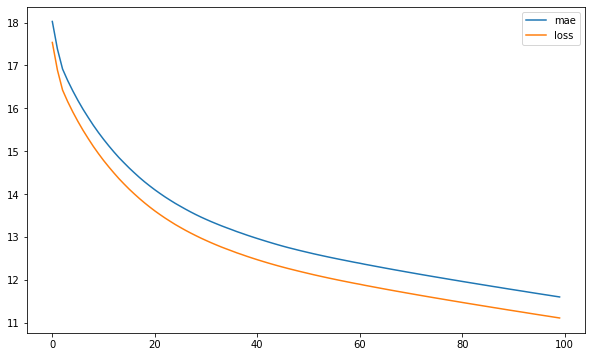

In [158]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(100), history.history['mae'], label = 'mae' )
plt.plot(np.arange(100), history.history['loss'], label = 'loss')
plt.legend()